In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sentence_transformers import SentenceTransformer, util
from nltk.tokenize import sent_tokenize
import torch
import nltk
from transformers import AutoTokenizer, AutoModel

### 통합데이터 read

In [2]:
df = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\kor_news_1st_preprocessed.csv')
df

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-12-01,2017-12-01 17:45:42,비트코인 하루만에 20% 폭락.. 금융당국 화폐가치 의견 갈려,“우리 시대 가장 큰 거품” “과거에도 급락 이후 회복” 지난달 사상 최초로...,6면 2단,https://n.news.naver.com/mnews/article/014/000...,2017-12-01 08:45:42,2017-12-01
1,2017-12-01,2017-12-01 17:31:22,'이게 통화냐' 경고에도 비트코인 포용 움직임 잇따라,"골드만삭스 CEO ""통화로 느껴지지 않아""…연준 부의장 ""금융시스템에 위협""""비트코...",연합뉴스,https://n.news.naver.com/mnews/article/001/000...,2017-12-01 08:31:22,2017-12-01
2,2017-12-01,2017-12-01 16:06:00,[매경e신문] 오늘의 프리미엄 (12월 2일),● [영상] 윤성은의 썸무비 올해 한국 영화 가성비 갑은?● 튤립버블부터 비트코인까...,매일경제,https://n.news.naver.com/mnews/article/009/000...,2017-12-01 07:06:00,2017-12-01
3,2017-12-01,2017-12-01 16:08:42,"[마감시황] 코스피, 외국인 ‘팔자’에 약보합 마감…코스닥은 780선 재진입",[헤럴드경제=최준선 기자] 장 내내 혼조세를 나타내던 코스피 지수가 끝내 외국인의 ...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2017-12-01 07:08:42,2017-12-01
4,2017-12-01,2017-12-01 16:22:11,[팩트체크]가상화폐 해킹은 불가능한가?,&lt;아이뉴스24&gt;[아이뉴스24 김다운기자] 지난달 20일 신생 가상화폐 거...,아이뉴스24언론사 선정,https://n.news.naver.com/mnews/article/031/000...,2017-12-01 07:22:11,2017-12-01
...,...,...,...,...,...,...,...,...
214709,2023-08-29,2023-08-29 08:31:04,"KAIST, 2023 테크페어 개최…사업화 유망기술 총집합",2023 KAIST 테크페어 포스터(KAIST 제공)/뉴스1(대전=뉴스1) 김태진 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2023-08-28 23:31:04,2023-08-28
214710,2023-08-29,2023-08-29 06:08:01,“금리 계속 높으면 물가 내릴 것”…나스닥 0.84%↑[데일리국제금융시장],"다우존스 0.62%↑, S&amp;P500 0.63%↑메타·애플·엔비디아 등 빅테크...",서울경제,https://n.news.naver.com/mnews/article/011/000...,2023-08-28 21:08:01,2023-08-28
214711,2023-08-29,2023-08-29 06:02:03,“자기 지키기 급급에 실망…1야당 본색 찾으면 다시 지지”[이재명 취임 1년...,"(하) 대선·총선 때 민주당 찍었지만 등돌린 시민들의 고언“마치 ‘선생님, 쟤 잘못...",A4면 TOP,https://n.news.naver.com/mnews/article/032/000...,2023-08-28 21:02:03,2023-08-28
214712,2023-08-29,2023-08-29 06:01:01,[체험기] 에코프로 공매도하고 싶었지만… 사회초년생에겐 너무 높은 문턱,"신규 개인투자자, 사전교육·모의거래 이수해야간신히 끝냈더니… 에코프로, 대주 거래 ...",조선비즈언론사 선정,https://n.news.naver.com/mnews/article/366/000...,2023-08-28 21:01:01,2023-08-28


In [3]:
# 'press' 열의 값을 세고 데이터프레임으로 변환
press_counts_df = df['press'].value_counts().reset_index()

press_counts_df.columns = ['press', 'count']

# 결과 출력
press_counts_df

,press,count
0,뉴스1,12971
1,이데일리,8405
2,파이낸셜뉴스,6521
3,뉴시스,6413
4,서울경제,6332
...,...,...
893,44면 TOP,1
894,56면 TOP,1
895,T18면 1단,1
896,15면 6단,1


In [4]:
press_counts_df.to_csv('kor_press_list.csv', encoding='utf-8-sig', index=False)

In [10]:
subset_data = df[df['UTC-date'] == '2021-06-24']
subset_data

,date,time,title,content,press,link,UTC-time,UTC-date
102912,2021-06-24,2021-06-24 15:38:04,[손에잡히는경제] 코인 상장수수료? 수십억 받는 곳도 있다,-방송 : MBC라디오 표준FM 95.9MHz &lt;이진우의 손에 잡히는 경제&g...,MBC,https://n.news.naver.com/mnews/article/214/000...,2021-06-24 06:38:04,2021-06-24
102913,2021-06-24,2021-06-24 15:39:49,'리플만 상승',(서울=뉴스1) 김명섭 기자 = 24일 서울 강남구 빗썸 강남고객센터에 비트코인을 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2021-06-24 06:39:49,2021-06-24
102914,2021-06-24,2021-06-24 15:38:08,"비트코인 국내가격 3,800만원대…이더리움 220만원대",24일 오후 국내 거래소에서 비트코인이 3천800만원대에 거래되고 있습니다.빗썸에 ...,SBS Biz,https://n.news.naver.com/mnews/article/374/000...,2021-06-24 06:38:08,2021-06-24
102915,2021-06-24,2021-06-24 15:32:03,남아공서 비트코인 4조원대 사기사건 발생 '사상 최대',[이데일리 정시내 기자] 아프리카 남아공에서 36억 달러(약4조원) 규모의 비트코인...,이데일리언론사 선정,https://n.news.naver.com/mnews/article/018/000...,2021-06-24 06:32:03,2021-06-24
102916,2021-06-24,2021-06-24 14:51:05,"FBI 국장 ""해커에 몸값 지불하면 사이버 공격 늘어""",(지디넷코리아=남혁우 기자)크리스 레이 연방수사국(FBI) 국장이 기업 및 피해자...,지디넷코리아,https://n.news.naver.com/mnews/article/092/000...,2021-06-24 05:51:05,2021-06-24
...,...,...,...,...,...,...,...,...
103297,2021-06-25,2021-06-25 08:52:56,[코인시황]비트코인 4000만원 다시 넘어서…알트코인도 상승,[서울=뉴시스]고범준 기자 = 지난 24일 오전 서울 강남구 암호화폐 거래소 빗썸 ...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,2021-06-24 23:52:56,2021-06-24
103298,2021-06-25,2021-06-25 01:13:02,"남아공서 쌍둥이 형제, 비트코인 4조원 사기친 후 종적 감춰",암호화폐 사기사건 중 사상 최대 규모사진=게티이미지뱅크남아프리카공화국에서 36억 달...,한국경제언론사 선정,https://n.news.naver.com/mnews/article/015/000...,2021-06-24 16:13:02,2021-06-24
103299,2021-06-25,2021-06-25 00:03:05,연내 금리 오른다…이주열 못박았다,"가계빚 1765조, 물가 더 뛸 가능성“연내 통화 정상화” 돈줄 죄기 나서“한두번 ...",A1면 1단,https://n.news.naver.com/mnews/article/025/000...,2021-06-24 15:03:05,2021-06-24
103300,2021-06-25,2021-06-25 00:01:06,[위클리 포토브리핑] 도그쇼 우승 견공의 위용과 남아공의 다이아몬드 러시,포토에디터가 뽑은 지난 한 주의 사진 제가 웨스트민스터도그쇼 우승자예요!6월 13...,조선일보,https://n.news.naver.com/mnews/article/023/000...,2021-06-24 15:01:06,2021-06-24


In [14]:
subset_data = subset_data[~subset_data['content'].isna()]

In [4]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('jhgan/ko-sbert-multitask')
model = AutoModel.from_pretrained('jhgan/ko-sbert-multitask')

# Mean Pooling Function
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Tokenize and Create Embeddings
def create_sentence_embeddings(contents):
    encoded_input = tokenizer(contents, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings

# Cosine Similarity Calculation Function
def cosine_similarity(embedding1, embedding2):
    return util.pytorch_cos_sim(embedding1, embedding2)

# Compute Similarity Matrix and Statistics
def compute_similarity_statistics(contents):
    sentence_embeddings = create_sentence_embeddings(contents)
    similarity_matrix = []

    for i in range(len(sentence_embeddings)):
        row = []
        for j in range(len(sentence_embeddings)):
            similarity = cosine_similarity(sentence_embeddings[i], sentence_embeddings[j]).item()
            row.append(similarity)
        similarity_matrix.append(row)

    return similarity_matrix

def cluster_and_filter_articles(group):
    try:
        contents = group['content'].tolist()
        sentence_embeddings = create_sentence_embeddings(contents)
        similarity_matrix = compute_similarity_statistics(contents)

        clusters = []
        visited = np.zeros(len(group), dtype=bool)

        for i in range(len(group)):
            if not visited[i]:
                similar_articles = np.where(np.array(similarity_matrix[i]) > 0.6)[0]
                clusters.append(similar_articles)
                visited[similar_articles] = True

        representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]
        return group.iloc[representative_indices].reset_index(drop=True)
    except Exception as e:
        print(f"Error at index {group.name}: {e}")
        return pd.DataFrame()
    


In [15]:
# Group and Filter Data
grouped_data = subset_data.groupby('UTC-date')
filtered_data = pd.DataFrame()

for date, group in grouped_data:
    try:
        filtered_group = cluster_and_filter_articles(group)
        filtered_data = pd.concat([filtered_data, filtered_group], ignore_index=True)
    except Exception as e:
        print(f"Error at date {date}: {e}")

print(filtered_data)

          date                 time  \
0   2021-06-24  2021-06-24 15:38:04   
1   2021-06-24  2021-06-24 15:39:49   
2   2021-06-24  2021-06-24 15:32:03   
3   2021-06-24  2021-06-24 14:51:05   
4   2021-06-24  2021-06-24 14:34:03   
5   2021-06-24  2021-06-24 15:00:04   
6   2021-06-24  2021-06-24 15:10:03   
7   2021-06-24  2021-06-24 14:55:09   
8   2021-06-24  2021-06-24 15:05:33   
9   2021-06-24  2021-06-24 15:18:42   
10  2021-06-24  2021-06-24 15:19:02   
11  2021-06-24  2021-06-24 15:14:06   
12  2021-06-24  2021-06-24 14:55:09   
13  2021-06-24  2021-06-24 10:15:45   
14  2021-06-24  2021-06-24 14:55:09   
15  2021-06-24  2021-06-24 09:45:08   
16  2021-06-24  2021-06-24 11:36:32   
17  2021-06-24  2021-06-24 10:56:49   
18  2021-06-24  2021-06-24 11:27:05   
19  2021-06-24  2021-06-24 11:12:02   
20  2021-06-24  2021-06-24 16:48:04   
21  2021-06-24  2021-06-24 12:11:35   
22  2021-06-24  2021-06-24 10:29:08   
23  2021-06-24  2021-06-24 17:21:11   
24  2021-06-24  2021-06-2

In [17]:
df_final = pd.read_csv('sim_del_naver_news_data_v5.csv')
df_final

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-12-01,2017-12-01 17:45:42,비트코인 하루만에 20% 폭락.. 금융당국 화폐가치 의견 갈려,“우리 시대 가장 큰 거품” “과거에도 급락 이후 회복” 지난달 사상 최초로...,6면 2단,https://n.news.naver.com/mnews/article/014/000...,2017-12-01 08:45:42,2017-12-01
1,2017-12-01,2017-12-01 16:06:00,[매경e신문] 오늘의 프리미엄 (12월 2일),● [영상] 윤성은의 썸무비 올해 한국 영화 가성비 갑은?● 튤립버블부터 비트코인까...,매일경제,https://n.news.naver.com/mnews/article/009/000...,2017-12-01 07:06:00,2017-12-01
2,2017-12-01,2017-12-01 16:08:42,"[마감시황] 코스피, 외국인 ‘팔자’에 약보합 마감…코스닥은 780선 재진입",[헤럴드경제=최준선 기자] 장 내내 혼조세를 나타내던 코스피 지수가 끝내 외국인의 ...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2017-12-01 07:08:42,2017-12-01
3,2017-12-01,2017-12-01 17:37:17,"송영무 ""北 해상봉쇄 정부차원 검토""…靑 ""宋 장관 개인의견""","[앵커]송영무 국방부 장관이 대북 제재 차원에서 거론되는 해상봉쇄 조치에 대해 ""그...",TV조선,https://n.news.naver.com/mnews/article/448/000...,2017-12-01 08:37:17,2017-12-01
4,2017-12-01,2017-12-01 17:31:22,'이게 통화냐' 경고에도 비트코인 포용 움직임 잇따라,"골드만삭스 CEO ""통화로 느껴지지 않아""…연준 부의장 ""금융시스템에 위협""""비트코...",연합뉴스,https://n.news.naver.com/mnews/article/001/000...,2017-12-01 08:31:22,2017-12-01
...,...,...,...,...,...,...,...,...
47860,2023-08-28,2023-08-28 11:02:03,"관세청, 범죄 자금세탁 통로 '불법환전' 집중단속",쪼개기 환전 등 주요 불법행위 점검…적발 시 등록취소 등 엄정 대응기사와 직접적 관...,노컷뉴스,https://n.news.naver.com/mnews/article/079/000...,2023-08-28 02:02:03,2023-08-28
47861,2023-08-29,2023-08-29 08:31:04,"KAIST, 2023 테크페어 개최…사업화 유망기술 총집합",2023 KAIST 테크페어 포스터(KAIST 제공)/뉴스1(대전=뉴스1) 김태진 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2023-08-28 23:31:04,2023-08-28
47862,2023-08-29,2023-08-29 06:08:01,“금리 계속 높으면 물가 내릴 것”…나스닥 0.84%↑[데일리국제금융시장],"다우존스 0.62%↑, S&amp;P500 0.63%↑메타·애플·엔비디아 등 빅테크...",서울경제,https://n.news.naver.com/mnews/article/011/000...,2023-08-28 21:08:01,2023-08-28
47863,2023-08-29,2023-08-29 06:01:01,[체험기] 에코프로 공매도하고 싶었지만… 사회초년생에겐 너무 높은 문턱,"신규 개인투자자, 사전교육·모의거래 이수해야간신히 끝냈더니… 에코프로, 대주 거래 ...",조선비즈언론사 선정,https://n.news.naver.com/mnews/article/366/000...,2023-08-28 21:01:01,2023-08-28


In [18]:
filtered_data = pd.concat([filtered_data, df_final], axis=0)
filtered_data

,date,time,title,content,press,link,UTC-time,UTC-date
0,2021-06-24,2021-06-24 15:38:04,[손에잡히는경제] 코인 상장수수료? 수십억 받는 곳도 있다,-방송 : MBC라디오 표준FM 95.9MHz &lt;이진우의 손에 잡히는 경제&g...,MBC,https://n.news.naver.com/mnews/article/214/000...,2021-06-24 06:38:04,2021-06-24
1,2021-06-24,2021-06-24 15:39:49,'리플만 상승',(서울=뉴스1) 김명섭 기자 = 24일 서울 강남구 빗썸 강남고객센터에 비트코인을 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2021-06-24 06:39:49,2021-06-24
2,2021-06-24,2021-06-24 15:32:03,남아공서 비트코인 4조원대 사기사건 발생 '사상 최대',[이데일리 정시내 기자] 아프리카 남아공에서 36억 달러(약4조원) 규모의 비트코인...,이데일리언론사 선정,https://n.news.naver.com/mnews/article/018/000...,2021-06-24 06:32:03,2021-06-24
3,2021-06-24,2021-06-24 14:51:05,"FBI 국장 ""해커에 몸값 지불하면 사이버 공격 늘어""",(지디넷코리아=남혁우 기자)크리스 레이 연방수사국(FBI) 국장이 기업 및 피해자...,지디넷코리아,https://n.news.naver.com/mnews/article/092/000...,2021-06-24 05:51:05,2021-06-24
4,2021-06-24,2021-06-24 14:34:03,"中 가상자산 채굴업체, 단속 피해 美 텍사스로…왜?",가상자산 정책과 법적 틀 분명…전기료도 비교적 저렴[AP][헤럴드경제=박세환 기자]...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2021-06-24 05:34:03,2021-06-24
...,...,...,...,...,...,...,...,...
47860,2023-08-28,2023-08-28 11:02:03,"관세청, 범죄 자금세탁 통로 '불법환전' 집중단속",쪼개기 환전 등 주요 불법행위 점검…적발 시 등록취소 등 엄정 대응기사와 직접적 관...,노컷뉴스,https://n.news.naver.com/mnews/article/079/000...,2023-08-28 02:02:03,2023-08-28
47861,2023-08-29,2023-08-29 08:31:04,"KAIST, 2023 테크페어 개최…사업화 유망기술 총집합",2023 KAIST 테크페어 포스터(KAIST 제공)/뉴스1(대전=뉴스1) 김태진 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2023-08-28 23:31:04,2023-08-28
47862,2023-08-29,2023-08-29 06:08:01,“금리 계속 높으면 물가 내릴 것”…나스닥 0.84%↑[데일리국제금융시장],"다우존스 0.62%↑, S&amp;P500 0.63%↑메타·애플·엔비디아 등 빅테크...",서울경제,https://n.news.naver.com/mnews/article/011/000...,2023-08-28 21:08:01,2023-08-28
47863,2023-08-29,2023-08-29 06:01:01,[체험기] 에코프로 공매도하고 싶었지만… 사회초년생에겐 너무 높은 문턱,"신규 개인투자자, 사전교육·모의거래 이수해야간신히 끝냈더니… 에코프로, 대주 거래 ...",조선비즈언론사 선정,https://n.news.naver.com/mnews/article/366/000...,2023-08-28 21:01:01,2023-08-28


In [20]:
filtered_data = filtered_data.sort_values(by='UTC-date')
filtered_data

,date,time,title,content,press,link,UTC-time,UTC-date
17,2017-12-01,2017-12-01 23:31:55,[본방사수] ‘그것이 알고 싶다’ 버지니아 한인 살인사건,[한겨레] ‘버지니아 한인 살인사건’ 7년째 미궁 그것이 알고 싶다(에스비에...,A19면 1단,https://n.news.naver.com/mnews/article/028/000...,2017-12-01 14:31:55,2017-12-01
0,2017-12-01,2017-12-01 17:45:42,비트코인 하루만에 20% 폭락.. 금융당국 화폐가치 의견 갈려,“우리 시대 가장 큰 거품” “과거에도 급락 이후 회복” 지난달 사상 최초로...,6면 2단,https://n.news.naver.com/mnews/article/014/000...,2017-12-01 08:45:42,2017-12-01
1,2017-12-01,2017-12-01 16:06:00,[매경e신문] 오늘의 프리미엄 (12월 2일),● [영상] 윤성은의 썸무비 올해 한국 영화 가성비 갑은?● 튤립버블부터 비트코인까...,매일경제,https://n.news.naver.com/mnews/article/009/000...,2017-12-01 07:06:00,2017-12-01
2,2017-12-01,2017-12-01 16:08:42,"[마감시황] 코스피, 외국인 ‘팔자’에 약보합 마감…코스닥은 780선 재진입",[헤럴드경제=최준선 기자] 장 내내 혼조세를 나타내던 코스피 지수가 끝내 외국인의 ...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2017-12-01 07:08:42,2017-12-01
3,2017-12-01,2017-12-01 17:37:17,"송영무 ""北 해상봉쇄 정부차원 검토""…靑 ""宋 장관 개인의견""","[앵커]송영무 국방부 장관이 대북 제재 차원에서 거론되는 해상봉쇄 조치에 대해 ""그...",TV조선,https://n.news.naver.com/mnews/article/448/000...,2017-12-01 08:37:17,2017-12-01
...,...,...,...,...,...,...,...,...
47838,2023-08-28,2023-08-28 10:18:02,"쟁글, 블록체인 대중화 논의하는 '인터 링크드' 행사 개최","9월4일 오전 10시 강남구 드리움서 개최…""인프라·모듈화 주제""가상자산(암호화폐)...",뉴스1,https://n.news.naver.com/mnews/article/421/000...,2023-08-28 01:18:02,2023-08-28
47837,2023-08-28,2023-08-28 15:06:05,보안인재 10만 양성 내세웠지만…인적관리도 안돼,정보보호 인력수요 조사 미흡인적자원개발위원회 못 꾸려업계 “정부 관리 부실” 목소리...,1면 TOP,https://n.news.naver.com/mnews/article/030/000...,2023-08-28 06:06:05,2023-08-28
47863,2023-08-29,2023-08-29 06:01:01,[체험기] 에코프로 공매도하고 싶었지만… 사회초년생에겐 너무 높은 문턱,"신규 개인투자자, 사전교육·모의거래 이수해야간신히 끝냈더니… 에코프로, 대주 거래 ...",조선비즈언론사 선정,https://n.news.naver.com/mnews/article/366/000...,2023-08-28 21:01:01,2023-08-28
47849,2023-08-28,2023-08-28 14:34:26,"가상자산 거래소, 9월부터 '최소 30억' 준비금 쌓아야…원화거래소만 순항",은행연합회 실명계좌 운영지침 중 '준비금 적립'만 9월부터 조기 시행원화 거래소는 ...,뉴스1언론사 선정,https://n.news.naver.com/mnews/article/421/000...,2023-08-28 05:34:26,2023-08-28


In [61]:
df_final = filtered_data
df_final

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-12-01,2017-12-01 17:45:42,비트코인 하루만에 20% 폭락.. 금융당국 화폐가치 의견 갈려,“우리 시대 가장 큰 거품” “과거에도 급락 이후 회복” 지난달 사상 최초로...,6면 2단,https://n.news.naver.com/mnews/article/014/000...,2017-12-01 08:45:42,2017-12-01
1,2017-12-01,2017-12-01 16:06:00,[매경e신문] 오늘의 프리미엄 (12월 2일),● [영상] 윤성은의 썸무비 올해 한국 영화 가성비 갑은?● 튤립버블부터 비트코인까...,매일경제,https://n.news.naver.com/mnews/article/009/000...,2017-12-01 07:06:00,2017-12-01
2,2017-12-01,2017-12-01 16:08:42,"[마감시황] 코스피, 외국인 ‘팔자’에 약보합 마감…코스닥은 780선 재진입",[헤럴드경제=최준선 기자] 장 내내 혼조세를 나타내던 코스피 지수가 끝내 외국인의 ...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2017-12-01 07:08:42,2017-12-01
3,2017-12-01,2017-12-01 17:37:17,"송영무 ""北 해상봉쇄 정부차원 검토""…靑 ""宋 장관 개인의견""","[앵커]송영무 국방부 장관이 대북 제재 차원에서 거론되는 해상봉쇄 조치에 대해 ""그...",TV조선,https://n.news.naver.com/mnews/article/448/000...,2017-12-01 08:37:17,2017-12-01
4,2017-12-01,2017-12-01 17:31:22,'이게 통화냐' 경고에도 비트코인 포용 움직임 잇따라,"골드만삭스 CEO ""통화로 느껴지지 않아""…연준 부의장 ""금융시스템에 위협""""비트코...",연합뉴스,https://n.news.naver.com/mnews/article/001/000...,2017-12-01 08:31:22,2017-12-01
...,...,...,...,...,...,...,...,...
47860,2023-08-28,2023-08-28 11:02:03,"관세청, 범죄 자금세탁 통로 '불법환전' 집중단속",쪼개기 환전 등 주요 불법행위 점검…적발 시 등록취소 등 엄정 대응기사와 직접적 관...,노컷뉴스,https://n.news.naver.com/mnews/article/079/000...,2023-08-28 02:02:03,2023-08-28
47861,2023-08-29,2023-08-29 08:31:04,"KAIST, 2023 테크페어 개최…사업화 유망기술 총집합",2023 KAIST 테크페어 포스터(KAIST 제공)/뉴스1(대전=뉴스1) 김태진 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2023-08-28 23:31:04,2023-08-28
47862,2023-08-29,2023-08-29 06:08:01,“금리 계속 높으면 물가 내릴 것”…나스닥 0.84%↑[데일리국제금융시장],"다우존스 0.62%↑, S&amp;P500 0.63%↑메타·애플·엔비디아 등 빅테크...",서울경제,https://n.news.naver.com/mnews/article/011/000...,2023-08-28 21:08:01,2023-08-28
47863,2023-08-29,2023-08-29 06:01:01,[체험기] 에코프로 공매도하고 싶었지만… 사회초년생에겐 너무 높은 문턱,"신규 개인투자자, 사전교육·모의거래 이수해야간신히 끝냈더니… 에코프로, 대주 거래 ...",조선비즈언론사 선정,https://n.news.naver.com/mnews/article/366/000...,2023-08-28 21:01:01,2023-08-28


In [59]:
data = df

In [74]:
# Define the date range and specific date to filter
start_date = '2021-06-24'
end_date = '2021-06-24'

# Convert the 'date' column to datetime if it is not already
data['UTC-date'] = pd.to_datetime(data['UTC-date'])

# Create the subset_data DataFrame by filtering the date range and specific date
subset_data = data[
    (data['UTC-date'] >= start_date) &
    (data['UTC-date'] <= end_date)
]

subset_data

# test_data = data[data['date'].str.startswith('2017-11')]
# test_data

AttributeError: module 'pandas' has no attribute 'to_date'

In [56]:
filtered_data


,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-12-01,2017-12-01 17:45:42,비트코인 하루만에 20% 폭락.. 금융당국 화폐가치 의견 갈려,“우리 시대 가장 큰 거품” “과거에도 급락 이후 회복” 지난달 사상 최초로...,6면 2단,https://n.news.naver.com/mnews/article/014/000...,2017-12-01 08:45:42,2017-12-01
1,2017-12-01,2017-12-01 16:06:00,[매경e신문] 오늘의 프리미엄 (12월 2일),● [영상] 윤성은의 썸무비 올해 한국 영화 가성비 갑은?● 튤립버블부터 비트코인까...,매일경제,https://n.news.naver.com/mnews/article/009/000...,2017-12-01 07:06:00,2017-12-01
2,2017-12-01,2017-12-01 16:08:42,"[마감시황] 코스피, 외국인 ‘팔자’에 약보합 마감…코스닥은 780선 재진입",[헤럴드경제=최준선 기자] 장 내내 혼조세를 나타내던 코스피 지수가 끝내 외국인의 ...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2017-12-01 07:08:42,2017-12-01
3,2017-12-01,2017-12-01 17:37:17,"송영무 ""北 해상봉쇄 정부차원 검토""…靑 ""宋 장관 개인의견""","[앵커]송영무 국방부 장관이 대북 제재 차원에서 거론되는 해상봉쇄 조치에 대해 ""그...",TV조선,https://n.news.naver.com/mnews/article/448/000...,2017-12-01 08:37:17,2017-12-01
4,2017-12-01,2017-12-01 17:31:22,'이게 통화냐' 경고에도 비트코인 포용 움직임 잇따라,"골드만삭스 CEO ""통화로 느껴지지 않아""…연준 부의장 ""금융시스템에 위협""""비트코...",연합뉴스,https://n.news.naver.com/mnews/article/001/000...,2017-12-01 08:31:22,2017-12-01
...,...,...,...,...,...,...,...,...
47860,2023-08-28,2023-08-28 11:02:03,"관세청, 범죄 자금세탁 통로 '불법환전' 집중단속",쪼개기 환전 등 주요 불법행위 점검…적발 시 등록취소 등 엄정 대응기사와 직접적 관...,노컷뉴스,https://n.news.naver.com/mnews/article/079/000...,2023-08-28 02:02:03,2023-08-28
47861,2023-08-29,2023-08-29 08:31:04,"KAIST, 2023 테크페어 개최…사업화 유망기술 총집합",2023 KAIST 테크페어 포스터(KAIST 제공)/뉴스1(대전=뉴스1) 김태진 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2023-08-28 23:31:04,2023-08-28
47862,2023-08-29,2023-08-29 06:08:01,“금리 계속 높으면 물가 내릴 것”…나스닥 0.84%↑[데일리국제금융시장],"다우존스 0.62%↑, S&amp;P500 0.63%↑메타·애플·엔비디아 등 빅테크...",서울경제,https://n.news.naver.com/mnews/article/011/000...,2023-08-28 21:08:01,2023-08-28
47863,2023-08-29,2023-08-29 06:01:01,[체험기] 에코프로 공매도하고 싶었지만… 사회초년생에겐 너무 높은 문턱,"신규 개인투자자, 사전교육·모의거래 이수해야간신히 끝냈더니… 에코프로, 대주 거래 ...",조선비즈언론사 선정,https://n.news.naver.com/mnews/article/366/000...,2023-08-28 21:01:01,2023-08-28


In [22]:
# # 인덱스 재설정
# filtered_df_final = filtered_groups.reset_index(drop=True)

# 'date'와 'time' 열 제거
filtered_df_final = filtered_data.drop(columns=['date', 'time'])

# 'UTC-date'와 'UTC-time'을 0, 1번 열로 재배치
cols = filtered_df_final.columns.tolist()
cols.insert(0, cols.pop(cols.index('UTC-date')))
cols.insert(1, cols.pop(cols.index('UTC-time')))
filtered_df_final = filtered_df_final[cols]
filtered_df_final

,UTC-date,UTC-time,title,content,press,link
17,2017-12-01,2017-12-01 14:31:55,[본방사수] ‘그것이 알고 싶다’ 버지니아 한인 살인사건,[한겨레] ‘버지니아 한인 살인사건’ 7년째 미궁 그것이 알고 싶다(에스비에...,A19면 1단,https://n.news.naver.com/mnews/article/028/000...
0,2017-12-01,2017-12-01 08:45:42,비트코인 하루만에 20% 폭락.. 금융당국 화폐가치 의견 갈려,“우리 시대 가장 큰 거품” “과거에도 급락 이후 회복” 지난달 사상 최초로...,6면 2단,https://n.news.naver.com/mnews/article/014/000...
1,2017-12-01,2017-12-01 07:06:00,[매경e신문] 오늘의 프리미엄 (12월 2일),● [영상] 윤성은의 썸무비 올해 한국 영화 가성비 갑은?● 튤립버블부터 비트코인까...,매일경제,https://n.news.naver.com/mnews/article/009/000...
2,2017-12-01,2017-12-01 07:08:42,"[마감시황] 코스피, 외국인 ‘팔자’에 약보합 마감…코스닥은 780선 재진입",[헤럴드경제=최준선 기자] 장 내내 혼조세를 나타내던 코스피 지수가 끝내 외국인의 ...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...
3,2017-12-01,2017-12-01 08:37:17,"송영무 ""北 해상봉쇄 정부차원 검토""…靑 ""宋 장관 개인의견""","[앵커]송영무 국방부 장관이 대북 제재 차원에서 거론되는 해상봉쇄 조치에 대해 ""그...",TV조선,https://n.news.naver.com/mnews/article/448/000...
...,...,...,...,...,...,...
47838,2023-08-28,2023-08-28 01:18:02,"쟁글, 블록체인 대중화 논의하는 '인터 링크드' 행사 개최","9월4일 오전 10시 강남구 드리움서 개최…""인프라·모듈화 주제""가상자산(암호화폐)...",뉴스1,https://n.news.naver.com/mnews/article/421/000...
47837,2023-08-28,2023-08-28 06:06:05,보안인재 10만 양성 내세웠지만…인적관리도 안돼,정보보호 인력수요 조사 미흡인적자원개발위원회 못 꾸려업계 “정부 관리 부실” 목소리...,1면 TOP,https://n.news.naver.com/mnews/article/030/000...
47863,2023-08-28,2023-08-28 21:01:01,[체험기] 에코프로 공매도하고 싶었지만… 사회초년생에겐 너무 높은 문턱,"신규 개인투자자, 사전교육·모의거래 이수해야간신히 끝냈더니… 에코프로, 대주 거래 ...",조선비즈언론사 선정,https://n.news.naver.com/mnews/article/366/000...
47849,2023-08-28,2023-08-28 05:34:26,"가상자산 거래소, 9월부터 '최소 30억' 준비금 쌓아야…원화거래소만 순항",은행연합회 실명계좌 운영지침 중 '준비금 적립'만 9월부터 조기 시행원화 거래소는 ...,뉴스1언론사 선정,https://n.news.naver.com/mnews/article/421/000...


In [23]:
# `title`이 동일한 경우 중복 행 삭제
filtered_df_final = filtered_df_final.drop_duplicates(subset='title')

# `content`가 동일한 경우 중복 행 삭제
filtered_df_final = filtered_df_final.drop_duplicates(subset='content')
filtered_df_final

,UTC-date,UTC-time,title,content,press,link
17,2017-12-01,2017-12-01 14:31:55,[본방사수] ‘그것이 알고 싶다’ 버지니아 한인 살인사건,[한겨레] ‘버지니아 한인 살인사건’ 7년째 미궁 그것이 알고 싶다(에스비에...,A19면 1단,https://n.news.naver.com/mnews/article/028/000...
0,2017-12-01,2017-12-01 08:45:42,비트코인 하루만에 20% 폭락.. 금융당국 화폐가치 의견 갈려,“우리 시대 가장 큰 거품” “과거에도 급락 이후 회복” 지난달 사상 최초로...,6면 2단,https://n.news.naver.com/mnews/article/014/000...
1,2017-12-01,2017-12-01 07:06:00,[매경e신문] 오늘의 프리미엄 (12월 2일),● [영상] 윤성은의 썸무비 올해 한국 영화 가성비 갑은?● 튤립버블부터 비트코인까...,매일경제,https://n.news.naver.com/mnews/article/009/000...
2,2017-12-01,2017-12-01 07:08:42,"[마감시황] 코스피, 외국인 ‘팔자’에 약보합 마감…코스닥은 780선 재진입",[헤럴드경제=최준선 기자] 장 내내 혼조세를 나타내던 코스피 지수가 끝내 외국인의 ...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...
3,2017-12-01,2017-12-01 08:37:17,"송영무 ""北 해상봉쇄 정부차원 검토""…靑 ""宋 장관 개인의견""","[앵커]송영무 국방부 장관이 대북 제재 차원에서 거론되는 해상봉쇄 조치에 대해 ""그...",TV조선,https://n.news.naver.com/mnews/article/448/000...
...,...,...,...,...,...,...
47838,2023-08-28,2023-08-28 01:18:02,"쟁글, 블록체인 대중화 논의하는 '인터 링크드' 행사 개최","9월4일 오전 10시 강남구 드리움서 개최…""인프라·모듈화 주제""가상자산(암호화폐)...",뉴스1,https://n.news.naver.com/mnews/article/421/000...
47837,2023-08-28,2023-08-28 06:06:05,보안인재 10만 양성 내세웠지만…인적관리도 안돼,정보보호 인력수요 조사 미흡인적자원개발위원회 못 꾸려업계 “정부 관리 부실” 목소리...,1면 TOP,https://n.news.naver.com/mnews/article/030/000...
47863,2023-08-28,2023-08-28 21:01:01,[체험기] 에코프로 공매도하고 싶었지만… 사회초년생에겐 너무 높은 문턱,"신규 개인투자자, 사전교육·모의거래 이수해야간신히 끝냈더니… 에코프로, 대주 거래 ...",조선비즈언론사 선정,https://n.news.naver.com/mnews/article/366/000...
47849,2023-08-28,2023-08-28 05:34:26,"가상자산 거래소, 9월부터 '최소 30억' 준비금 쌓아야…원화거래소만 순항",은행연합회 실명계좌 운영지침 중 '준비금 적립'만 9월부터 조기 시행원화 거래소는 ...,뉴스1언론사 선정,https://n.news.naver.com/mnews/article/421/000...


In [19]:
print(len(filtered_df))
print(len(filtered_df_final))

222969
22209


In [25]:
filtered_df_final.to_csv('sim_del_naver_news_data_v5.csv', encoding='utf-8-sig', index=False)

In [26]:
filtered_data = pd.read_csv('sim_del_naver_news_data_v5.csv', encoding='utf-8-sig')

In [27]:
filtered_data

,UTC-date,UTC-time,title,content,press,link
0,2017-12-01,2017-12-01 14:31:55,[본방사수] ‘그것이 알고 싶다’ 버지니아 한인 살인사건,[한겨레] ‘버지니아 한인 살인사건’ 7년째 미궁 그것이 알고 싶다(에스비에...,A19면 1단,https://n.news.naver.com/mnews/article/028/000...
1,2017-12-01,2017-12-01 08:45:42,비트코인 하루만에 20% 폭락.. 금융당국 화폐가치 의견 갈려,“우리 시대 가장 큰 거품” “과거에도 급락 이후 회복” 지난달 사상 최초로...,6면 2단,https://n.news.naver.com/mnews/article/014/000...
2,2017-12-01,2017-12-01 07:06:00,[매경e신문] 오늘의 프리미엄 (12월 2일),● [영상] 윤성은의 썸무비 올해 한국 영화 가성비 갑은?● 튤립버블부터 비트코인까...,매일경제,https://n.news.naver.com/mnews/article/009/000...
3,2017-12-01,2017-12-01 07:08:42,"[마감시황] 코스피, 외국인 ‘팔자’에 약보합 마감…코스닥은 780선 재진입",[헤럴드경제=최준선 기자] 장 내내 혼조세를 나타내던 코스피 지수가 끝내 외국인의 ...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...
4,2017-12-01,2017-12-01 08:37:17,"송영무 ""北 해상봉쇄 정부차원 검토""…靑 ""宋 장관 개인의견""","[앵커]송영무 국방부 장관이 대북 제재 차원에서 거론되는 해상봉쇄 조치에 대해 ""그...",TV조선,https://n.news.naver.com/mnews/article/448/000...
...,...,...,...,...,...,...
44291,2023-08-28,2023-08-28 01:18:02,"쟁글, 블록체인 대중화 논의하는 '인터 링크드' 행사 개최","9월4일 오전 10시 강남구 드리움서 개최…""인프라·모듈화 주제""가상자산(암호화폐)...",뉴스1,https://n.news.naver.com/mnews/article/421/000...
44292,2023-08-28,2023-08-28 06:06:05,보안인재 10만 양성 내세웠지만…인적관리도 안돼,정보보호 인력수요 조사 미흡인적자원개발위원회 못 꾸려업계 “정부 관리 부실” 목소리...,1면 TOP,https://n.news.naver.com/mnews/article/030/000...
44293,2023-08-28,2023-08-28 21:01:01,[체험기] 에코프로 공매도하고 싶었지만… 사회초년생에겐 너무 높은 문턱,"신규 개인투자자, 사전교육·모의거래 이수해야간신히 끝냈더니… 에코프로, 대주 거래 ...",조선비즈언론사 선정,https://n.news.naver.com/mnews/article/366/000...
44294,2023-08-28,2023-08-28 05:34:26,"가상자산 거래소, 9월부터 '최소 30억' 준비금 쌓아야…원화거래소만 순항",은행연합회 실명계좌 운영지침 중 '준비금 적립'만 9월부터 조기 시행원화 거래소는 ...,뉴스1언론사 선정,https://n.news.naver.com/mnews/article/421/000...


In [28]:
# 필터링된 결과를 날짜별로 그룹화하고 카운트
datewise_counts_non_empty = filtered_data.groupby('UTC-date').size()

datewise_counts_non_empty

UTC-date
2017-12-01    22
2017-12-02     6
2017-12-03    16
2017-12-04    24
2017-12-05    21
              ..
2023-08-24    28
2023-08-25    17
2023-08-26     8
2023-08-27    15
2023-08-28    28
Length: 2097, dtype: int64

count    2097.000000
mean       21.123510
std        11.454003
min         1.000000
25%        13.000000
50%        19.000000
75%        29.000000
max       149.000000
dtype: float64


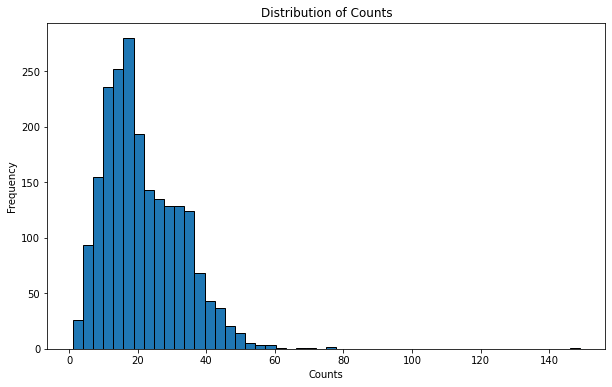

In [29]:
# 기본 통계 요약
print(datewise_counts_non_empty.describe())

# 히스토그램
plt.figure(figsize=(10, 6))
datewise_counts_non_empty.hist(bins=50, edgecolor='black')
plt.title("Distribution of Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [26]:
data = filtered_df_final
data

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,\n\n\n\n\n© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2016-12-31 22:00:00,2016-12-31
1,2017-01-01,2017-01-01 07:02:03,"2017년 주식 투자…IT, 인프라 ‘솔깃’ 해외주식도 담아보자",\n\t\t\t[헤럴드경제=김지헌 기자] 올해도 지루한 박스피(박스권에 갇힌 코스피...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2016-12-31 22:02:03,2016-12-31
2,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",\n【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다.\n ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,2017-01-01 06:15:04,2017-01-01
3,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",\n\t\t\t“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블...,39면 1단,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 07:03:04,2017-01-01
4,2017-01-01,2017-01-01 12:03:13,[2017 국제 핫이슈]블록체인 기술 확산,\n\t\t\t블록체인은 `제2의 인터넷` `넥스트 인터넷`으로 불린다. 새해에는 ...,전자신문,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 03:03:13,2017-01-01
...,...,...,...,...,...,...,...,...
161562,2023-08-30,2023-08-30 10:31:36,올해 상반기 금융사 '의심 거래' 보고 10% 늘어,\n\t\t\t올해 상반기 금융사들의 의심 거래 보고 건수가 지난해보다 10% 가까...,YTN,https://n.news.naver.com/mnews/article/052/000...,2023-08-30 01:31:36,2023-08-30
161563,2023-08-30,2023-08-30 09:12:12,훨훨 난 비트코인…현물 ETF 상장 호재에 6% 급등,"\n비트코인, 박스권 깨고 3700만원 돌파\n\n\n\n[서울=뉴시스]이지영 기자...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:12:12,2023-08-30
161564,2023-08-30,2023-08-30 09:41:23,"이원욱 ""이재명 1년, 미래도 유능함도 없는 민주당 돼""","\n이원욱 ""민주, 여전히 이재명의 대표리스크""""정치 훌리건의 공격 난무하는 친명 ...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:41:23,2023-08-30
161565,2023-08-30,2023-08-30 10:18:01,"업비트, “FDS로 250억 규모 보이스피싱 차단…이상거래 철통방어”",\n\n\n\n\n사진=업비트업비트가 자체 이상거래 탐지시스템(FDS)으로 사전 차...,14면 3단,https://n.news.naver.com/mnews/article/030/000...,2023-08-30 01:18:01,2023-08-30


In [15]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Load data
data = pd.read_csv('test.csv')

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
model.eval()

# Embed each article content using BERT
embeddings = []
for content in data['content'].tolist():
    tokens = tokenizer(content, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    with torch.no_grad():
        out = model(**tokens)
    embeddings.append(out['pooler_output'].squeeze().numpy())

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Cluster articles based on similarity
clusters = []
visited = np.zeros(len(data), dtype=bool)
for i in range(len(data)):
    if not visited[i]:
        similar_articles = np.where(similarity_matrix[i] > 0.6)[0]
        clusters.append(similar_articles)
        visited[similar_articles] = True

# Get representative articles from each cluster
representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]

# Create a dataframe with only representative articles
filtered_data = data.iloc[representative_indices].reset_index(drop=True)
filtered_data


c:\Users\user\anaconda3\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


,date,time,title,content,press,link,year
0,2018-06-10,2018-06-10 20:32:13,"벤처스퀘어 ""블록체인과 스타트업 주제 컨퍼런스 14일 개최""",\r\n\t\t\t서울창업허브에서 10회 'GSC' 행사...비트코인 전도사 로저버...,지디넷코리아,https://n.news.naver.com/mnews/article/092/000...,2018


In [8]:
from sentence_transformers import SentenceTransformer
sentences = ["안녕하세요?", "한국어 문장 임베딩을 위한 버트 모델입니다."]

model = SentenceTransformer('jhgan/ko-sbert-multitask')
embeddings = model.encode(sentences)
print(embeddings)

[[-0.74153584 -1.3282459   0.4284346  ...  0.29576957 -0.15558366
  -0.06287863]
 [ 0.42207116 -0.348227    0.6715514  ...  0.52206224  0.3279075
  -0.49290675]]


In [9]:
from transformers import AutoTokenizer, AutoModel
import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('jhgan/ko-sbert-multitask')
model = AutoModel.from_pretrained('jhgan/ko-sbert-multitask')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, mean pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

print("Sentence embeddings:")
print(sentence_embeddings)


c:\Users\user\anaconda3\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Sentence embeddings:
tensor([[ 0.8179, -0.5759,  0.4884,  ..., -0.2551,  1.1708, -0.8680],
        [ 0.1106, -0.5015, -0.0669,  ..., -0.0188,  0.5766, -0.9011]])
